In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import mlflow
import mlflow.sklearn
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configurações
plt.style.use('seaborn-v0_8')
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [3]:
# Carregar dados da análise exploratória
try:
    df = pd.read_csv('../data/raw/house_prices.csv')
    print(f"✅ Dataset carregado: {df.shape}")
except FileNotFoundError:
    print("❌ Arquivo não encontrado. Execute primeiro o notebook de EDA.")
    raise

✅ Dataset carregado: (984, 7)


In [4]:
# Verificar integridade dos dados
print(f"Colunas: {list(df.columns)}")
print(f"Tipos de dados:\n{df.dtypes}")
print(f"Valores nulos: {df.isnull().sum().sum()}")

# Visualizar primeiras linhas
print("Primeiras 5 linhas do dataset:")
display(df.head())

print("\nEstatísticas básicas:")
display(df.describe())



Colunas: ['area', 'quartos', 'banheiros', 'idade', 'garagem', 'bairro', 'preco']
Tipos de dados:
area         float64
quartos        int64
banheiros      int64
idade        float64
garagem        int64
bairro        object
preco        float64
dtype: object
Valores nulos: 0
Primeiras 5 linhas do dataset:


,area,quartos,banheiros,idade,garagem,bairro,preco
0,139.868566,2,2,10.450279,0,Zona Norte,400126.122658
1,114.469428,2,1,0.769949,0,Zona Oeste,416187.943469
2,145.907542,3,1,4.707542,1,Zona Norte,442924.309508
3,180.921194,3,2,16.286949,1,Centro,823804.522652
4,110.633865,1,3,5.682292,0,Zona Oeste,402452.118358



Estatísticas básicas:


,area,quartos,banheiros,idade,garagem,preco
count,984.000000,984.000000,984.000000,984.000000,984.000000,9.840000e+02
mean,121.442344,2.809959,2.160569,9.341083,0.701220,4.914064e+05
std,38.285078,1.035220,0.803496,8.773926,0.457956,1.823873e+05
min,31.554588,1.000000,1.000000,0.000307,0.000000,1.382248e+05
25%,94.817117,2.000000,2.000000,2.855801,0.000000,3.542938e+05
50%,121.170019,3.000000,2.000000,6.697531,1.000000,4.596822e+05
75%,146.019948,3.000000,3.000000,13.114059,1.000000,6.139950e+05
max,274.109260,5.000000,4.000000,49.038182,1.000000,1.258970e+06


In [5]:
## 2. Engenharia de Features

def prepare_features(data, fit_encoder=True, encoder=None):
    """
    Prepara features para treinamento do modelo
    
    Args:
        data: DataFrame com dados originais
        fit_encoder: Se deve treinar o encoder (True para treino)
        encoder: Encoder já treinado (para teste)
    
    Returns:
        X: Features preparadas
        encoder: Label encoder (se fit_encoder=True)
    """
    df_prep = data.copy()
    
    print("🔧 Iniciando engenharia de features...")
    
    # 1. Encoding da variável categórica 'bairro'
    if fit_encoder:
        label_encoder = LabelEncoder()
        df_prep['bairro_encoded'] = label_encoder.fit_transform(df_prep['bairro'])
        print(f"✅ Bairros codificados: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
    else:
        if encoder is None:
            raise ValueError("Encoder necessário quando fit_encoder=False")
        df_prep['bairro_encoded'] = encoder.transform(df_prep['bairro'])
        label_encoder = encoder
    
    # 2. Features derivadas
    df_prep['area_per_room'] = df_prep['area'] / (df_prep['quartos'] + 1)  # +1 para evitar divisão por zero
    df_prep['bathroom_ratio'] = df_prep['banheiros'] / df_prep['quartos']
    df_prep['age_squared'] = df_prep['idade'] ** 2
    df_prep['total_rooms'] = df_prep['quartos'] + df_prep['banheiros']
    df_prep['is_new'] = (df_prep['idade'] < 5).astype(int)  # Imóvel novo (< 5 anos)
    
    print("✅ Features derivadas criadas:")
    print("  - area_per_room: área por quarto")
    print("  - bathroom_ratio: razão banheiros/quartos")
    print("  - age_squared: idade ao quadrado")
    print("  - total_rooms: total de cômodos")
    print("  - is_new: imóvel novo (< 5 anos)")
    
    # 3. Selecionar features para o modelo
    feature_columns = [
        'area', 'quartos', 'banheiros', 'idade', 'garagem', 'bairro_encoded',
        'area_per_room', 'bathroom_ratio', 'age_squared', 'total_rooms', 'is_new'
    ]
    
    X = df_prep[feature_columns]
    
    print(f"✅ Features selecionadas: {len(feature_columns)} variáveis")
    print(f"Shape final: {X.shape}")
    
    if fit_encoder:
        return X, label_encoder
    else:
        return X


# Aplicar engenharia de features
X, label_encoder = prepare_features(df, fit_encoder=True)
y = df['preco']

print(f"\nDataset preparado:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nNomes das features:")
for i, col in enumerate(X.columns):
    print(f"  {i+1:2d}. {col}")
    
    
# Verificar correlações das novas features
correlation_with_target = X.corrwith(y).sort_values(key=abs, ascending=False)

print("📊 Correlação das features com o preço:")
for feature, corr in correlation_with_target.items():
    direction = "positiva" if corr > 0 else "negativa" 
    strength = "forte" if abs(corr) > 0.7 else "moderada" if abs(corr) > 0.3 else "fraca"
    print(f"  {feature:15s}: {corr:6.3f} (correlação {strength} {direction})")




🔧 Iniciando engenharia de features...
✅ Bairros codificados: {'Centro': 0, 'Zona Leste': 1, 'Zona Norte': 2, 'Zona Oeste': 3, 'Zona Sul': 4}
✅ Features derivadas criadas:
  - area_per_room: área por quarto
  - bathroom_ratio: razão banheiros/quartos
  - age_squared: idade ao quadrado
  - total_rooms: total de cômodos
  - is_new: imóvel novo (< 5 anos)
✅ Features selecionadas: 11 variáveis
Shape final: (984, 11)

Dataset preparado:
Features (X): (984, 11)
Target (y): (984,)

Nomes das features:
   1. area
   2. quartos
   3. banheiros
   4. idade
   5. garagem
   6. bairro_encoded
   7. area_per_room
   8. bathroom_ratio
   9. age_squared
  10. total_rooms
  11. is_new
📊 Correlação das features com o preço:
  area           :  0.717 (correlação forte positiva)
  area_per_room  :  0.438 (correlação moderada positiva)
  bairro_encoded :  0.322 (correlação moderada positiva)
  total_rooms    :  0.128 (correlação fraca positiva)
  quartos        :  0.108 (correlação fraca positiva)
  garage

📊 Divisão dos dados:
Treino: X=(787, 11), y=(787,)
Teste:  X=(197, 11), y=(197,)

Divisão para desenvolvimento:
Treino:    X=(629, 11), y=(629,)
Validação: X=(158, 11), y=(158,)
Teste:     X=(197, 11), y=(197,)
📈 Distribuição do target por conjunto:
Treino     - Média: R$ 492,547, Std: R$ 184,941
Validação  - Média: R$ 488,750, Std: R$ 187,456
Teste      - Média: R$ 489,896, Std: R$ 170,543


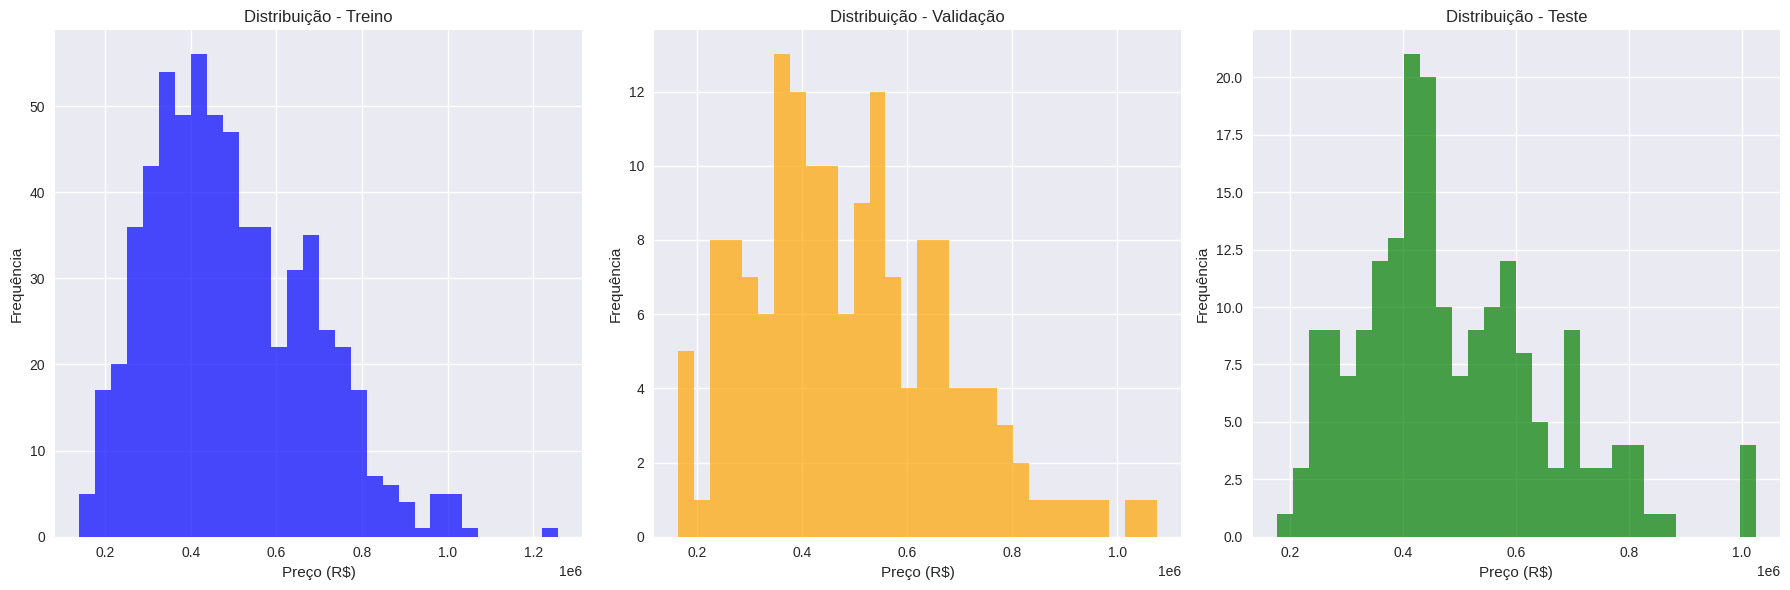

In [6]:
## 3. Divisão dos Dados

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Divisão dos dados:")
print(f"Treino: X={X_train.shape}, y={y_train.shape}")
print(f"Teste:  X={X_test.shape}, y={y_test.shape}")

# Dividir treino em treino e validação
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\nDivisão para desenvolvimento:")
print(f"Treino:    X={X_train_split.shape}, y={y_train_split.shape}")
print(f"Validação: X={X_val.shape}, y={y_val.shape}")
print(f"Teste:     X={X_test.shape}, y={y_test.shape}")

# %%
# Verificar distribuição do target nos conjuntos
print("📈 Distribuição do target por conjunto:")
print(f"Treino     - Média: R$ {y_train_split.mean():,.0f}, Std: R$ {y_train_split.std():,.0f}")
print(f"Validação  - Média: R$ {y_val.mean():,.0f}, Std: R$ {y_val.std():,.0f}")
print(f"Teste      - Média: R$ {y_test.mean():,.0f}, Std: R$ {y_test.std():,.0f}")

# Visualizar distribuições
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist(y_train_split, bins=30, alpha=0.7, label='Treino', color='blue')
axes[0].set_title('Distribuição - Treino')
axes[0].set_xlabel('Preço (R$)')
axes[0].set_ylabel('Frequência')

axes[1].hist(y_val, bins=30, alpha=0.7, label='Validação', color='orange')
axes[1].set_title('Distribuição - Validação')
axes[1].set_xlabel('Preço (R$)')
axes[1].set_ylabel('Frequência')

axes[2].hist(y_test, bins=30, alpha=0.7, label='Teste', color='green')
axes[2].set_title('Distribuição - Teste')
axes[2].set_xlabel('Preço (R$)')
axes[2].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [7]:
## 4. Configurar MLflow

# Configurar MLflow para tracking de experimentos
try:
    mlflow.set_experiment("house-price-prediction-development")
    print("✅ MLflow configurado - Experimento: house-price-prediction-development")
except:
    print("⚠️ MLflow não disponível - executando sem tracking")

✅ MLflow configurado - Experimento: house-price-prediction-development


In [8]:
# avaliar modelo
def evaluate_model(model, X_eval, y_eval, dataset_name="Dataset"):
    """
    Avalia o modelo e retorna métricas detalhadas
    """
    predictions = model.predict(X_eval)
    
    # Métricas principais
    mse = mean_squared_error(y_eval, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_eval, predictions)
    r2 = r2_score(y_eval, predictions)
    
    # Métricas adicionais
    mape = np.mean(np.abs((y_eval - predictions) / y_eval)) * 100
    residuals = y_eval - predictions
    
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'mean_residual': residuals.mean(),
        'std_residual': residuals.std()
    }
    
    print(f"\n📊 {dataset_name} - Métricas de Avaliação:")
    print(f"  RMSE:  R$ {rmse:,.2f}")
    print(f"  MAE:   R$ {mae:,.2f}")
    print(f"  R²:    {r2:.4f}")
    print(f"  MAPE:  {mape:.2f}%")
    
    return metrics, predictions

🚀 Treinando modelo baseline...


2025/07/13 11:57:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Baseline - Validação - Métricas de Avaliação:
  RMSE:  R$ 33,147.30
  MAE:   R$ 26,973.59
  R²:    0.9685
  MAPE:  6.35%


2025/07/13 11:57:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Baseline logado no MLflow
📈 Importância das Features (Modelo Baseline):
  area           : 0.5861
  bairro_encoded : 0.3870
  area_per_room  : 0.0058
  total_rooms    : 0.0051
  age_squared    : 0.0044
  idade          : 0.0041
  quartos        : 0.0021
  bathroom_ratio : 0.0021
  banheiros      : 0.0013
  garagem        : 0.0013
  is_new         : 0.0006


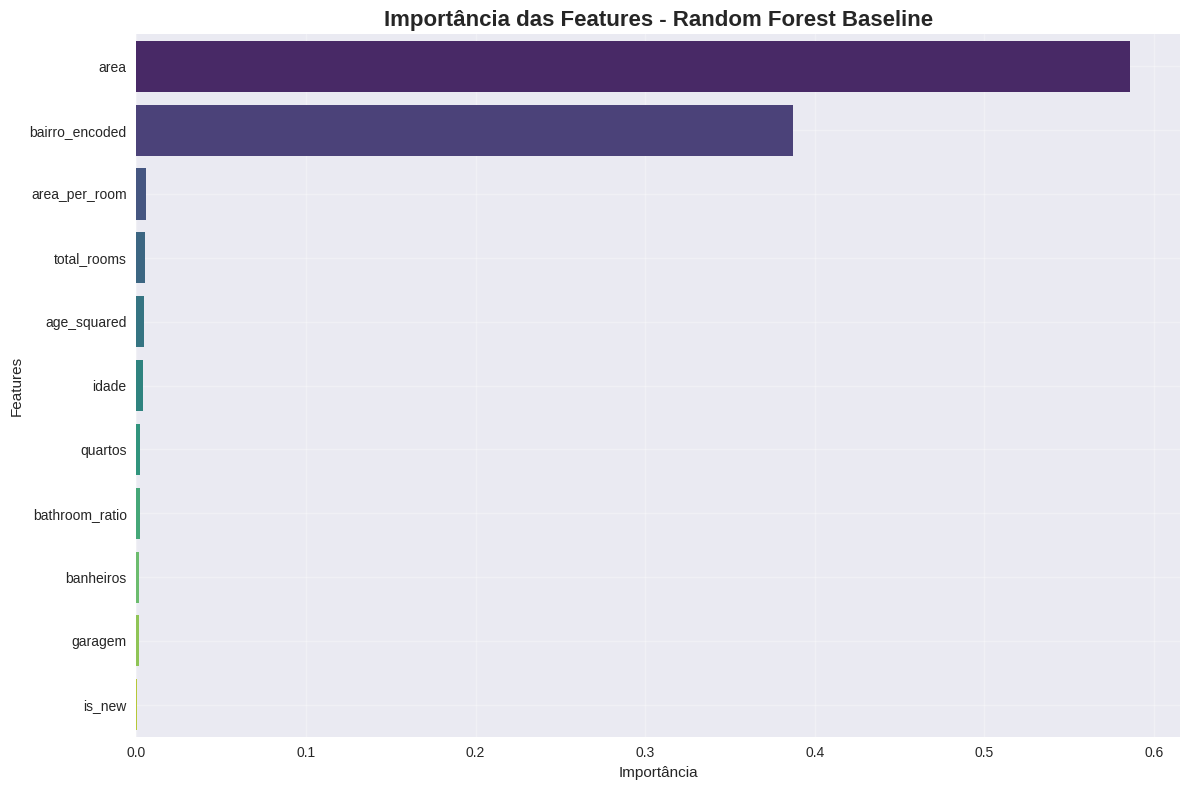

In [9]:
## 5. Modelo Baseline

print("🚀 Treinando modelo baseline...")

# Experimento 1: Modelo Baseline
baseline_params = {
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1
}

try:
    with mlflow.start_run(run_name="baseline_random_forest"):
        # Criar e treinar modelo baseline
        rf_baseline = RandomForestRegressor(**baseline_params)
        rf_baseline.fit(X_train_split, y_train_split)
        
        # Avaliar no conjunto de validação
        val_metrics, val_predictions = evaluate_model(
            rf_baseline, X_val, y_val, "Baseline - Validação"
        )
        
        # Log dos parâmetros no MLflow
        mlflow.log_params(baseline_params)
        mlflow.log_metrics({f"val_{k}": v for k, v in val_metrics.items()})
        mlflow.sklearn.log_model(rf_baseline, "model")
        
        print("✅ Baseline logado no MLflow")
        
except:
    # Executar sem MLflow se não estiver disponível
    rf_baseline = RandomForestRegressor(**baseline_params)
    rf_baseline.fit(X_train_split, y_train_split)
    val_metrics, val_predictions = evaluate_model(
        rf_baseline, X_val, y_val, "Baseline - Validação"
    )

baseline_metrics = val_metrics



# Importância das features do modelo baseline
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("📈 Importância das Features (Modelo Baseline):")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:15s}: {row['importance']:.4f}")

# Visualizar importância das features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')
plt.title('Importância das Features - Random Forest Baseline', fontsize=16, fontweight='bold')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
## 6. Otimização de Hiperparâmetros

print("🔧 Iniciando otimização de hiperparâmetros...")


# Definir grade de parâmetros para otimização
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print(f"📋 Parâmetros a testar:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"💡 Total de combinações: {total_combinations}")

# %%
try:
    with mlflow.start_run(run_name="hyperparameter_tuning"):
        # Executar Grid Search
        rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
        
        print("⏳ Executando Grid Search (isso pode demorar alguns minutos)...")
        grid_search = GridSearchCV(
            rf_grid, 
            param_grid, 
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train_split, y_train_split)
        
        # Melhor modelo encontrado
        best_rf = grid_search.best_estimator_
        
        print(f"\n🎯 Otimização concluída!")
        print(f"Melhores parâmetros: {grid_search.best_params_}")
        print(f"Melhor score CV (RMSE): {np.sqrt(-grid_search.best_score_):,.2f}")
        
        # Avaliar modelo otimizado
        tuned_metrics, tuned_predictions = evaluate_model(
            best_rf, X_val, y_val, "Otimizado - Validação"
        )
        
        # Log no MLflow
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("cv_rmse", np.sqrt(-grid_search.best_score_))
        mlflow.log_metrics({f"val_{k}": v for k, v in tuned_metrics.items()})
        mlflow.sklearn.log_model(best_rf, "model")
        
        print("✅ Modelo otimizado logado no MLflow")
        
except:
    # Fallback sem MLflow
    rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(
        rf_grid, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_split, y_train_split)
    best_rf = grid_search.best_estimator_
    tuned_metrics, tuned_predictions = evaluate_model(
        best_rf, X_val, y_val, "Otimizado - Validação"
    )

# Análise da otimização
print("📊 Resultados da Otimização:")
print(f"Melhores hiperparâmetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Comparar com baseline
improvement = {
    'rmse': (baseline_metrics['rmse'] - tuned_metrics['rmse']) / baseline_metrics['rmse'] * 100,
    'r2': (tuned_metrics['r2'] - baseline_metrics['r2']) / baseline_metrics['r2'] * 100,
    'mae': (baseline_metrics['mae'] - tuned_metrics['mae']) / baseline_metrics['mae'] * 100
}

print(f"\n📈 Melhoria em relação ao baseline:")
for metric, pct in improvement.items():
    direction = "melhoria" if pct > 0 else "piora"
    print(f"  {metric.upper()}: {abs(pct):.2f}% de {direction}")



🔧 Iniciando otimização de hiperparâmetros...
📋 Parâmetros a testar:
  n_estimators: [100, 200, 300]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]
💡 Total de combinações: 243
⏳ Executando Grid Search (isso pode demorar alguns minutos)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

🎯 Otimização concluída!
Melhores parâmetros: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor score CV (RMSE): 36,409.14


2025/07/13 12:04:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Otimizado - Validação - Métricas de Avaliação:
  RMSE:  R$ 32,787.41
  MAE:   R$ 26,691.22
  R²:    0.9692
  MAPE:  6.31%


2025/07/13 12:04:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo otimizado logado no MLflow
📊 Resultados da Otimização:
Melhores hiperparâmetros encontrados:
  max_depth: 10
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300

📈 Melhoria em relação ao baseline:
  RMSE: 1.09% de melhoria
  R2: 0.07% de melhoria
  MAE: 1.05% de melhoria


📊 Comparação de Modelos:


,Modelo,RMSE,MAE,R²,MAPE
0,Baseline,33147.3035,26973.5950,0.9685,6.3480
1,Otimizado,32787.4132,26691.2205,0.9692,6.3057



🏆 Melhor modelo: Otimizado


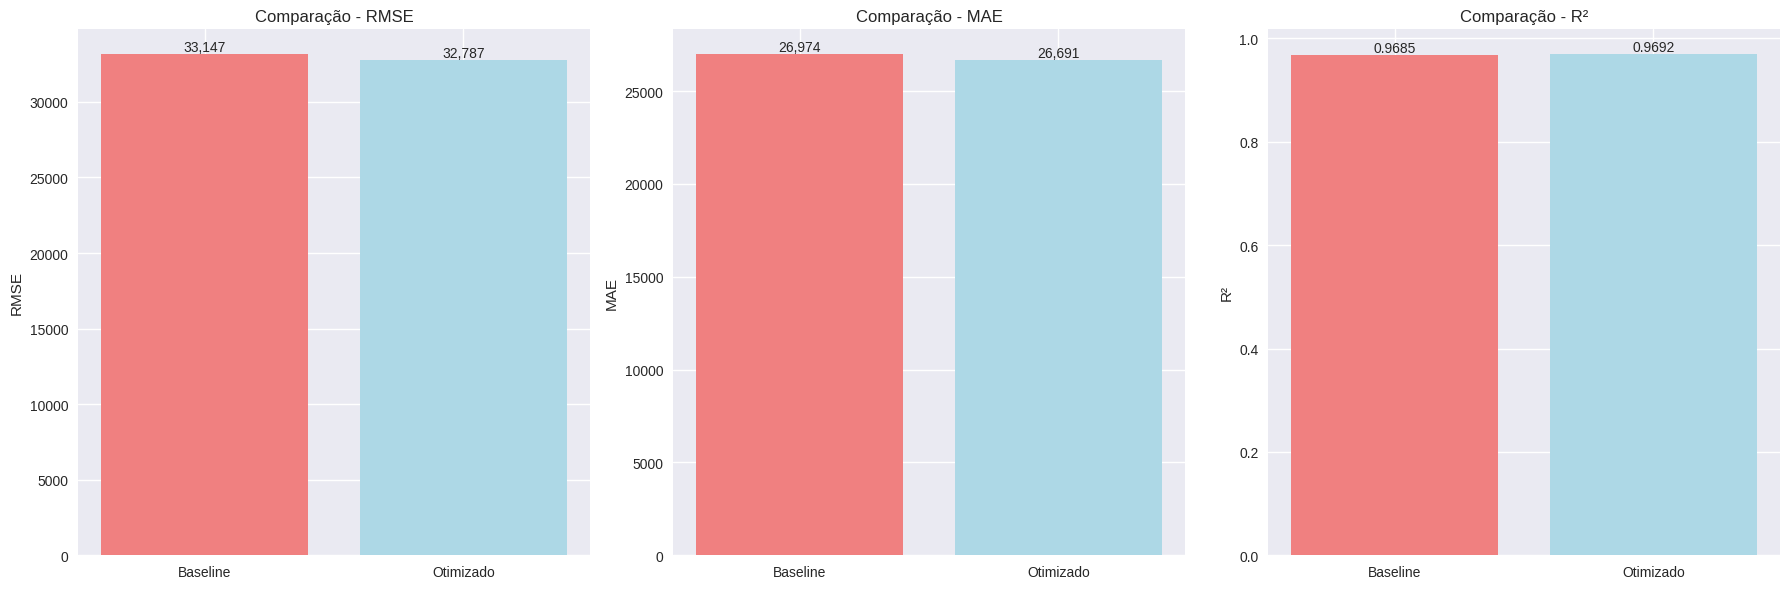

In [11]:
## 7. Comparação de Modelos

# Comparar métricas dos modelos
comparison_df = pd.DataFrame({
    'Modelo': ['Baseline', 'Otimizado'],
    'RMSE': [baseline_metrics['rmse'], tuned_metrics['rmse']],
    'MAE': [baseline_metrics['mae'], tuned_metrics['mae']],
    'R²': [baseline_metrics['r2'], tuned_metrics['r2']],
    'MAPE': [baseline_metrics['mape'], tuned_metrics['mape']]
})

print("📊 Comparação de Modelos:")
display(comparison_df.round(4))

# Escolher melhor modelo baseado em R²
if tuned_metrics['r2'] > baseline_metrics['r2']:
    best_model = best_rf
    best_model_name = "Otimizado"
    best_metrics = tuned_metrics
    print(f"\n🏆 Melhor modelo: {best_model_name}")
else:
    best_model = rf_baseline
    best_model_name = "Baseline"
    best_metrics = baseline_metrics
    print(f"\n🏆 Melhor modelo: {best_model_name}")
    

# Visualização da comparação
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_to_plot = ['RMSE', 'MAE', 'R²']
colors = ['lightcoral', 'lightblue']

for i, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].values
    bars = axes[i].bar(comparison_df['Modelo'], values, color=colors)
    axes[i].set_title(f'Comparação - {metric}')
    axes[i].set_ylabel(metric)
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}' if metric == 'R²' else f'{value:,.0f}',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()



🔄 Executando validação cruzada detalhada...
Mean Squared Error:
  Média: 1184469816.7267
  Desvio padrão: 181279117.6951
  Min: 1077819080.4404
  Max: 1546570819.4789
R2:
  Média: 0.9651
  Desvio padrão: 0.0060
  Min: 0.9549
  Max: 0.9721
Mean Absolute Error:
  Média: 25715.9110
  Desvio padrão: 445.3808
  Min: 25263.3013
  Max: 26492.8003


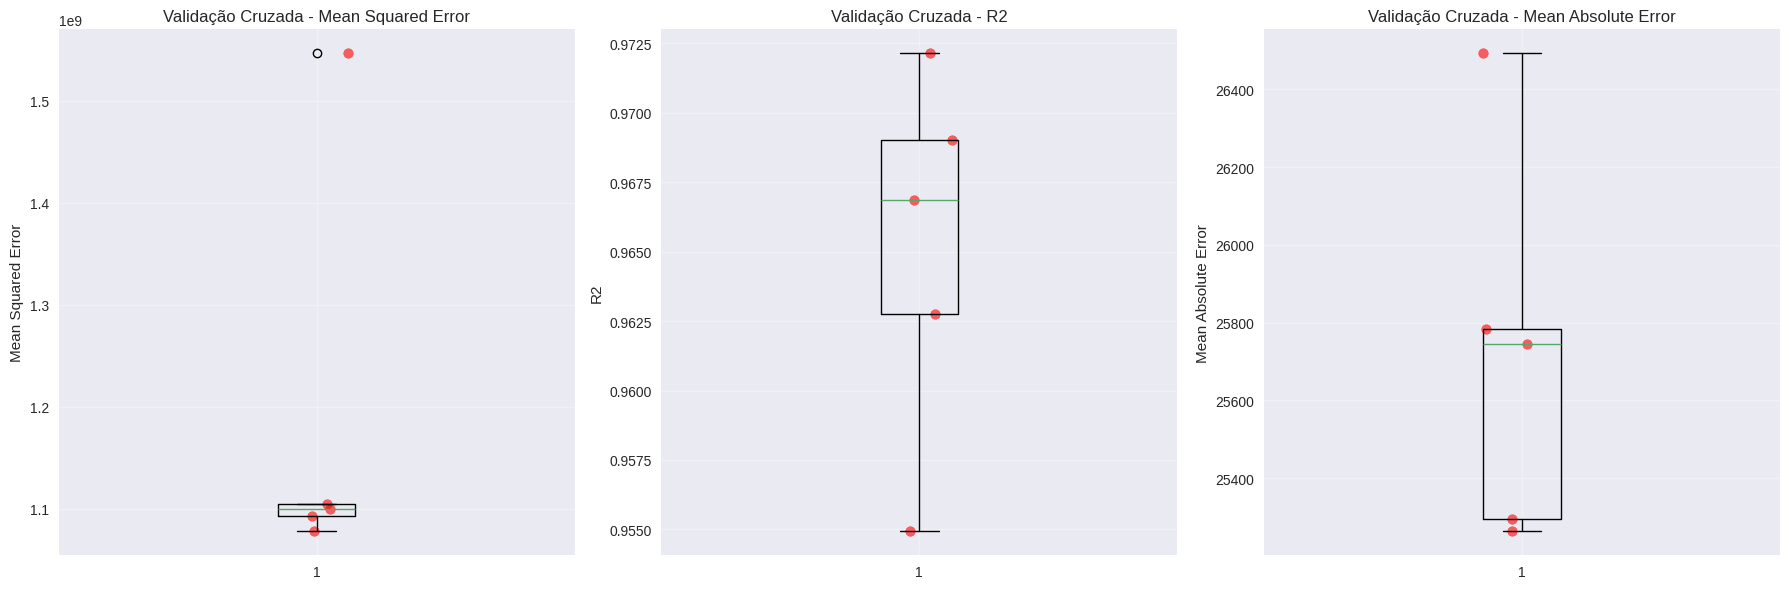

In [12]:
## 8. Validação Cruzada 

print("🔄 Executando validação cruzada detalhada...")

# Validação cruzada com diferentes métricas
cv_scores = {}
cv_folds = 5

for scoring in ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']:
    scores = cross_val_score(best_model, X_train, y_train, cv=cv_folds, scoring=scoring)
    
    if 'neg_' in scoring:
        scores = -scores  # Converter scores negativos
        metric_name = scoring.replace('neg_', '').replace('_', ' ').title()
    else:
        metric_name = scoring.replace('_', ' ').title()
    
    cv_scores[metric_name] = scores
    
    print(f"{metric_name}:")
    print(f"  Média: {scores.mean():.4f}")
    print(f"  Desvio padrão: {scores.std():.4f}")
    print(f"  Min: {scores.min():.4f}")
    print(f"  Max: {scores.max():.4f}")

# Visualizar resultados da validação cruzada
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (metric, scores) in enumerate(cv_scores.items()):
    axes[i].boxplot(scores)
    axes[i].set_title(f'Validação Cruzada - {metric}')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)
    
    # Adicionar pontos individuais
    y = scores
    x = np.random.normal(1, 0.04, len(y))
    axes[i].scatter(x, y, alpha=0.6, color='red')

plt.tight_layout()
plt.show()



In [13]:
# 9. Avaliação Final no Conjunto de Teste

print("🎯 Avaliação final no conjunto de teste...")

try:
    with mlflow.start_run(run_name="final_evaluation"):
        # Treinar modelo final em todo o conjunto de treino
        final_model = best_model
        final_model.fit(X_train, y_train)
        
        # Avaliar no conjunto de teste
        test_metrics, test_predictions = evaluate_model(
            final_model, X_test, y_test, "Final - Teste"
        )
        
        # Log das métricas finais
        mlflow.log_metrics({f"test_{k}": v for k, v in test_metrics.items()})
        mlflow.sklearn.log_model(final_model, "final_model")
        
        print("✅ Avaliação final logada no MLflow")
        
except:
    final_model = best_model
    final_model.fit(X_train, y_train)
    test_metrics, test_predictions = evaluate_model(
        final_model, X_test, y_test, "Final - Teste"
    )
    
# Métricas de todas as etapas
all_metrics = pd.DataFrame({
    'Validação': [val_metrics['rmse'], val_metrics['mae'], val_metrics['r2'], val_metrics['mape']],
    'Teste': [test_metrics['rmse'], test_metrics['mae'], test_metrics['r2'], test_metrics['mape']]
}, index=['RMSE', 'MAE', 'R²', 'MAPE'])

print("📊 Métricas Finais - Validação vs Teste:")
display(all_metrics.round(4))

# Verificar overfitting
if test_metrics['r2'] < val_metrics['r2'] - 0.05:
    print("⚠️ Possível overfitting detectado (R² teste << R² validação)")
else:
    print("✅ Modelo generaliza bem (sem overfitting significativo)")


🎯 Avaliação final no conjunto de teste...


2025/07/13 12:05:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Final - Teste - Métricas de Avaliação:
  RMSE:  R$ 30,881.87
  MAE:   R$ 23,859.87
  R²:    0.9670
  MAPE:  5.28%


2025/07/13 12:05:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Avaliação final logada no MLflow
📊 Métricas Finais - Validação vs Teste:


,Validação,Teste
RMSE,33147.3035,30881.8718
MAE,26973.5950,23859.8657
R²,0.9685,0.9670
MAPE,6.3480,5.2843


✅ Modelo generaliza bem (sem overfitting significativo)


🔍 Analisando resíduos do modelo...
📊 Estatísticas dos Resíduos:
  Média: R$ 220.55
  Desvio padrão: R$ 30,959.76
  Mínimo: R$ -75,709.25
  Máximo: R$ 139,703.40
  Mediana: R$ 578.71


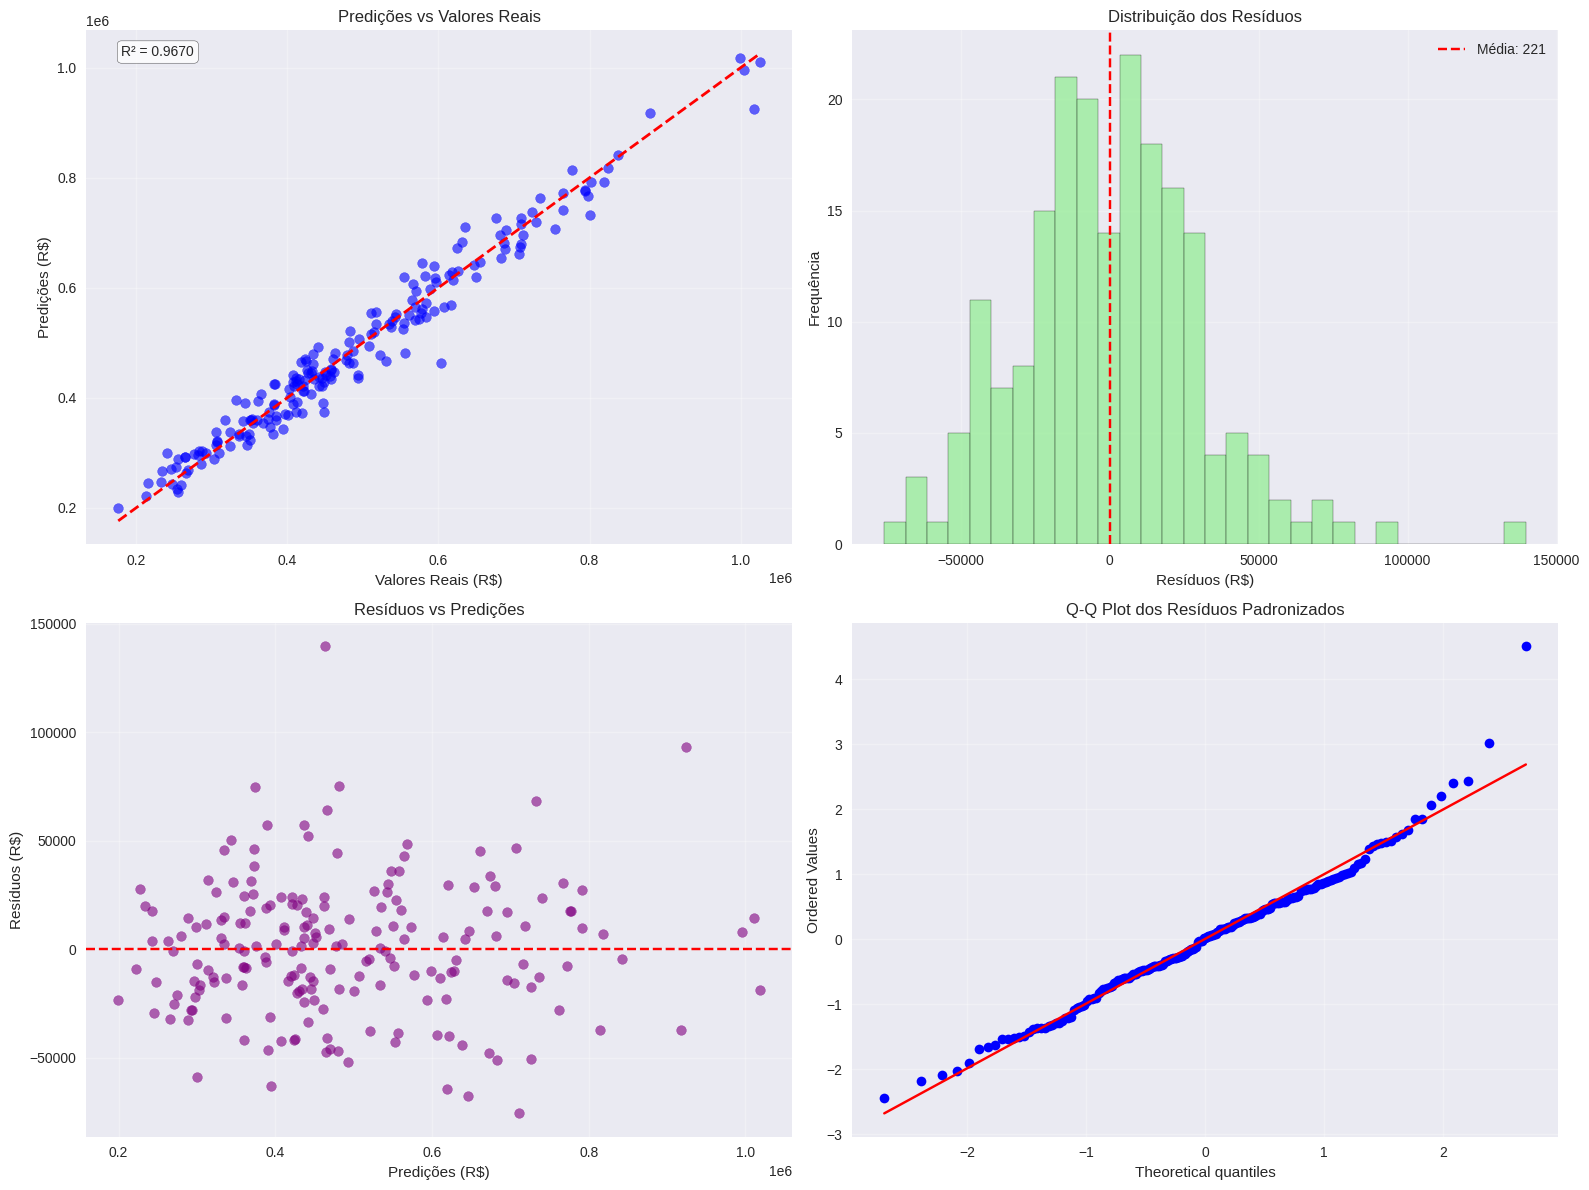

🔍 Análise de Outliers nos Resíduos:
  Threshold (2σ): R$ 61,919.52
  Outliers encontrados: 10 (5.1%)

Piores predições (maiores resíduos absolutos):


,Real,Predito,Residuo,Residuo_Abs
819,6.034597e+05,463756.345847,139703.398431,139703.398431
70,1.017523e+06,924072.166752,93451.018926,93451.018926
490,6.347584e+05,710467.607558,-75709.252402,75709.252402
218,5.560313e+05,480771.181087,75260.119382,75260.119382
299,4.485779e+05,373965.938095,74611.984783,74611.984783


In [14]:
## 10. Análise de Resíduos


print("🔍 Analisando resíduos do modelo...")

# Calcular resíduos
residuals = y_test - test_predictions
standardized_residuals = residuals / residuals.std()

# Estatísticas dos resíduos
print(f"📊 Estatísticas dos Resíduos:")
print(f"  Média: R$ {residuals.mean():,.2f}")
print(f"  Desvio padrão: R$ {residuals.std():,.2f}")
print(f"  Mínimo: R$ {residuals.min():,.2f}")
print(f"  Máximo: R$ {residuals.max():,.2f}")
print(f"  Mediana: R$ {residuals.median():,.2f}")

# Visualizações dos resíduos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predições vs Valores reais
axes[0, 0].scatter(y_test, test_predictions, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reais (R$)')
axes[0, 0].set_ylabel('Predições (R$)')
axes[0, 0].set_title('Predições vs Valores Reais')
axes[0, 0].grid(True, alpha=0.3)

# Adicionar R² no gráfico
r2_text = f'R² = {test_metrics["r2"]:.4f}'
axes[0, 0].text(0.05, 0.95, r2_text, transform=axes[0, 0].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Distribuição dos resíduos
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Média: {residuals.mean():,.0f}')
axes[0, 1].set_xlabel('Resíduos (R$)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição dos Resíduos')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Resíduos vs Predições
axes[1, 0].scatter(test_predictions, residuals, alpha=0.6, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predições (R$)')
axes[1, 0].set_ylabel('Resíduos (R$)')
axes[1, 0].set_title('Resíduos vs Predições')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot dos resíduos
from scipy import stats
stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot dos Resíduos Padronizados')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise de outliers nos resíduos
residual_threshold = 2 * residuals.std()
outliers_idx = np.abs(residuals) > residual_threshold
n_outliers = outliers_idx.sum()

print(f"🔍 Análise de Outliers nos Resíduos:")
print(f"  Threshold (2σ): R$ {residual_threshold:,.2f}")
print(f"  Outliers encontrados: {n_outliers} ({n_outliers/len(residuals)*100:.1f}%)")

if n_outliers > 0:
    print(f"\nPiores predições (maiores resíduos absolutos):")
    worst_predictions = pd.DataFrame({
        'Real': y_test,
        'Predito': test_predictions,
        'Residuo': residuals,
        'Residuo_Abs': np.abs(residuals)
    }).sort_values('Residuo_Abs', ascending=False).head(5)
    
    display(worst_predictions)

🏆 Importância das Features (Modelo Final):
  area           : 0.5779
  bairro_encoded : 0.3970
  total_rooms    : 0.0058
  area_per_room  : 0.0050
  age_squared    : 0.0036
  idade          : 0.0035
  quartos        : 0.0020
  bathroom_ratio : 0.0019
  banheiros      : 0.0014
  garagem        : 0.0014
  is_new         : 0.0004


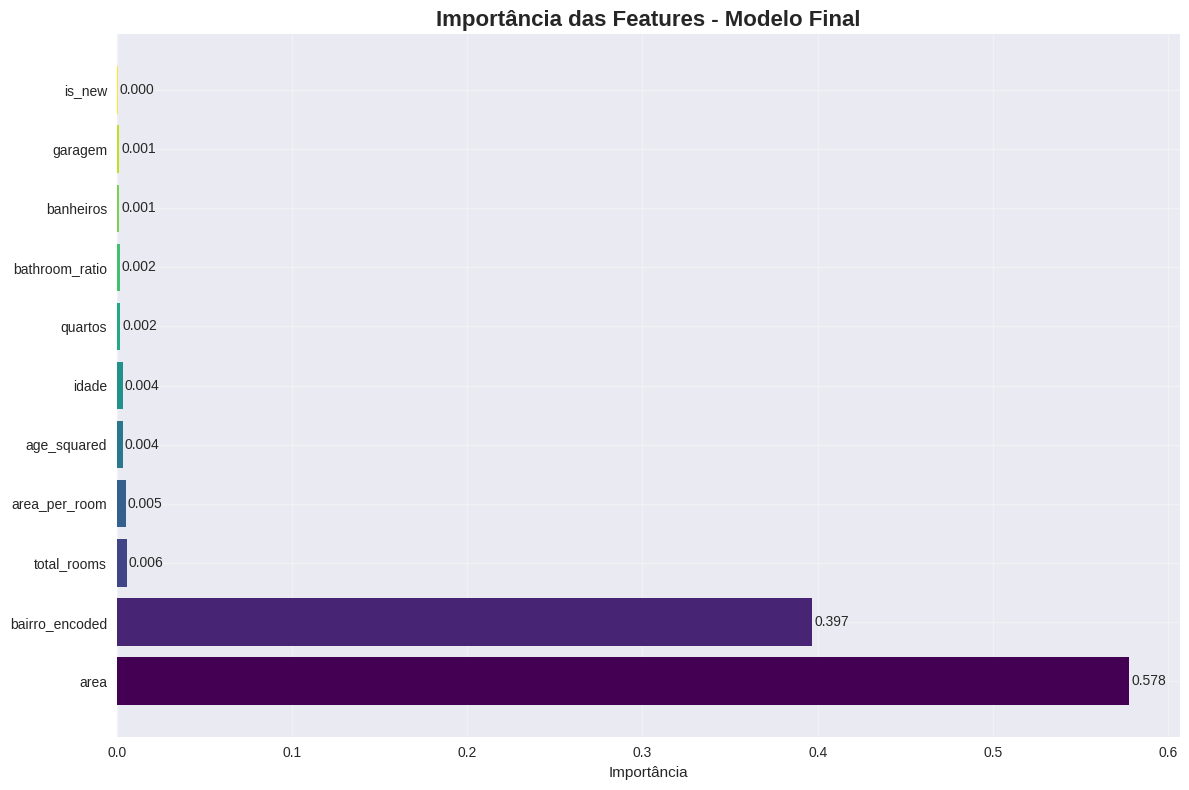

In [15]:
## 11. Importância das Features (Modelo Final)


# Importância das features do modelo final
final_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 Importância das Features (Modelo Final):")
for idx, row in final_importance.iterrows():
    print(f"  {row['feature']:15s}: {row['importance']:.4f}")

# Visualização da importância das features
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(final_importance)))
bars = plt.barh(range(len(final_importance)), final_importance['importance'], color=colors)

plt.yticks(range(len(final_importance)), final_importance['feature'])
plt.xlabel('Importância')
plt.title('Importância das Features - Modelo Final', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, (bar, importance) in enumerate(zip(bars, final_importance['importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

📈 Gerando curvas de aprendizado...


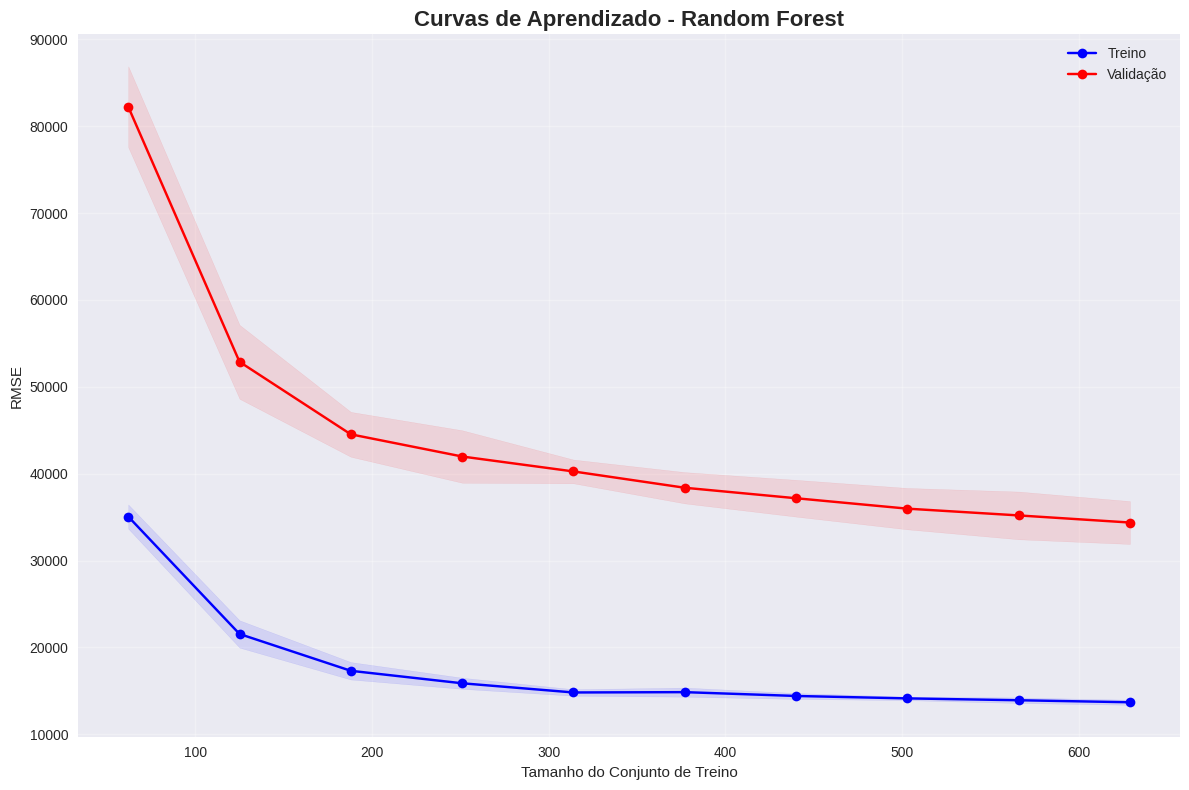

📊 Análise das Curvas de Aprendizado:
  RMSE Treino (final): 13,686.27
  RMSE Validação (final): 34,378.31
  Gap Treino-Validação: 20,692.03
❌ Overfitting significativo


In [16]:
## 12. Curvas de Aprendizado

from sklearn.model_selection import learning_curve

print("📈 Gerando curvas de aprendizado...")

# Calcular curvas de aprendizado
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error', 
    n_jobs=-1, random_state=42
)

# Converter para RMSE
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

# Calcular médias e desvios padrão
train_rmse_mean = train_rmse.mean(axis=1)
train_rmse_std = train_rmse.std(axis=1)
val_rmse_mean = val_rmse.mean(axis=1)
val_rmse_std = val_rmse.std(axis=1)


# Plotar curvas de aprendizado
plt.figure(figsize=(12, 8))

plt.plot(train_sizes, train_rmse_mean, 'o-', color='blue', label='Treino')
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, 
                 train_rmse_mean + train_rmse_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_rmse_mean, 'o-', color='red', label='Validação')
plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, 
                 val_rmse_mean + val_rmse_std, alpha=0.1, color='red')

plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('RMSE')
plt.title('Curvas de Aprendizado - Random Forest', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análise das curvas
gap_final = val_rmse_mean[-1] - train_rmse_mean[-1]
print(f"📊 Análise das Curvas de Aprendizado:")
print(f"  RMSE Treino (final): {train_rmse_mean[-1]:,.2f}")
print(f"  RMSE Validação (final): {val_rmse_mean[-1]:,.2f}")
print(f"  Gap Treino-Validação: {gap_final:,.2f}")

if gap_final < 10000:
    print("✅ Modelo bem balanceado (baixo overfitting)")
elif gap_final < 20000:
    print("⚠️ Overfitting moderado")
else:
    print("❌ Overfitting significativo")

In [18]:
# ## 13. Salvar Modelo e Artefatos

# %%
print("💾 Salvando modelo e artefatos...")

# Criar diretórios se não existirem
os.makedirs('../data/models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Salvar modelo final
model_path = '../data/models/random_forest_model.pkl'
joblib.dump(final_model, model_path)
print(f"✅ Modelo salvo: {model_path}")

# Salvar label encoder
encoder_path = '../data/models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"✅ Encoder salvo: {encoder_path}")

# Salvar dados processados
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('../data/processed/y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('../data/processed/y_test.csv', index=False)
print(f"✅ Dados processados salvos: ../data/processed/")

# %%
# Função para converter tipos numpy para tipos Python nativos
def convert_numpy_types(obj):
    """
    Converte tipos numpy para tipos Python nativos para serialização JSON
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    return obj

# Salvar métricas e metadados
metrics_summary = {
    'model_name': 'Random Forest Regressor',
    'model_type': best_model_name,
    'best_params': convert_numpy_types(grid_search.best_params_),
    'final_rmse': float(test_metrics['rmse']),
    'final_mae': float(test_metrics['mae']),
    'final_r2': float(test_metrics['r2']),
    'final_mape': float(test_metrics['mape']),
    'training_samples': int(len(X_train)),
    'test_samples': int(len(X_test)),
    'features': list(X.columns),
    'feature_importance': {str(k): float(v) for k, v in zip(final_importance['feature'], final_importance['importance'])},
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'cv_rmse_mean': float(np.sqrt(-grid_search.best_score_)),
    'residual_stats': {
        'mean': float(residuals.mean()),
        'std': float(residuals.std()),
        'outliers_count': int(n_outliers)
    }
}

metrics_path = '../data/models/model_metrics.json'
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)
print(f"✅ Métricas salvas: {metrics_path}")

# %%
# Salvar resumo para produção
production_summary = {
    'model_ready': True,
    'model_path': model_path,
    'encoder_path': encoder_path,
    'performance': {
        'r2_score': test_metrics['r2'],
        'rmse': test_metrics['rmse'],
        'mae': test_metrics['mae']
    },
    'features_required': list(X.columns),
    'deployment_ready': test_metrics['r2'] > 0.7  # Critério de qualidade
}

with open('../data/models/production_summary.json', 'w') as f:
    json.dump(production_summary, f, indent=2)

print("✅ Resumo para produção salvo")

💾 Salvando modelo e artefatos...
✅ Modelo salvo: ../data/models/random_forest_model.pkl
✅ Encoder salvo: ../data/models/label_encoder.pkl
✅ Dados processados salvos: ../data/processed/
✅ Métricas salvas: ../data/models/model_metrics.json
✅ Resumo para produção salvo


In [ ]:
# 14. Exemplo de Predição

def predict_house_price(area, quartos, banheiros, idade, garagem, bairro, 
                       model=final_model, encoder=label_encoder, show_details=True):
    """
    Prediz o preço de um imóvel com detalhes
    """
    try:
        # Preparar dados de entrada
        input_data = pd.DataFrame({
            'area': [area],
            'quartos': [quartos],
            'banheiros': [banheiros],
            'idade': [idade],
            'garagem': [garagem],
            'bairro': [bairro]
        })
        
        # Aplicar engenharia de features
        X_input = prepare_features(input_data, fit_encoder=False, encoder=encoder)
        
        # Fazer predição
        prediction = model.predict(X_input)[0]
        
        if show_details:
            print(f"🏠 Predição de Preço do Imóvel")
            print(f"{'='*40}")
            print(f"Características do imóvel:")
            print(f"  📐 Área: {area} m²")
            print(f"  🛏️  Quartos: {quartos}")
            print(f"  🚿 Banheiros: {banheiros}")
            print(f"  📅 Idade: {idade} anos")
            print(f"  🚗 Garagem: {'Sim' if garagem else 'Não'}")
            print(f"  📍 Bairro: {bairro}")
            print(f"{'='*40}")
            print(f"💰 Preço Predito: R$ {prediction:,.2f}")
            
            # Intervalo de confiança aproximado (usando std dos resíduos)
            std_error = residuals.std()
            lower_bound = prediction - 1.96 * std_error
            upper_bound = prediction + 1.96 * std_error
            print(f"📊 Intervalo de Confiança (95%): R$ {lower_bound:,.2f} - R$ {upper_bound:,.2f}")
        
        return prediction
        
    except Exception as e:
        print(f"❌ Erro na predição: {e}")
        return None


# Exemplos de predição
print("🎯 Exemplos de Predição:")


# Exemplo 1: Imóvel de alto padrão
exemplo1 = predict_house_price(
    area=150,
    quartos=3,
    banheiros=3,
    idade=2,
    garagem=1,
    bairro='Zona Sul'
)

# Exemplo 2: Imóvel padrão médio
exemplo2 = predict_house_price(
    area=80,
    quartos=2,
    banheiros=1,
    idade=15,
    garagem=0,
    bairro='Zona Norte'
)




🎯 Exemplos de Predição:
🔧 Iniciando engenharia de features...
✅ Features derivadas criadas:
  - area_per_room: área por quarto
  - bathroom_ratio: razão banheiros/quartos
  - age_squared: idade ao quadrado
  - total_rooms: total de cômodos
  - is_new: imóvel novo (< 5 anos)
✅ Features selecionadas: 11 variáveis
Shape final: (1, 11)
🏠 Predição de Preço do Imóvel
Características do imóvel:
  📐 Área: 150 m²
  🛏️  Quartos: 3
  🚿 Banheiros: 3
  📅 Idade: 2 anos
  🚗 Garagem: Sim
  📍 Bairro: Zona Sul
💰 Preço Predito: R$ 807,201.36
📊 Intervalo de Confiança (95%): R$ 746,520.22 - R$ 867,882.49
🔧 Iniciando engenharia de features...
✅ Features derivadas criadas:
  - area_per_room: área por quarto
  - bathroom_ratio: razão banheiros/quartos
  - age_squared: idade ao quadrado
  - total_rooms: total de cômodos
  - is_new: imóvel novo (< 5 anos)
✅ Features selecionadas: 11 variáveis
Shape final: (1, 11)
🏠 Predição de Preço do Imóvel
Características do imóvel:
  📐 Área: 80 m²
  🛏️  Quartos: 2
  🚿 Banhe